<h1>Randomized benchmarking</h1>
From a qualitative side

<h1>Introduction:</h1>
Randomized bechmarking is an experimental method for measuring the average error rate of quantum computing hardware platforms.

This technique is not well studied in the domain of dynamic circuits. So adding a tutorial about part of its working will have big effects.

In fact, in this notebook the circuits used for this technique will be explained and a graph comparing the results will be plotted. But numerical calculations of parameters and rates will not be studied. Instead an explanation of the graph will be given.

<h1>Outline:</h1>


*   Installing required libraries
*   Circuits design
*   Checking circuits run time
*   Conclusion and remarks



<h1>Installing required libraries</h1>

In [1]:
!pip install qiskit['all']

In [2]:
!pip install qiskit-aer

<h1>Circuits design</h1>

In [3]:
import qiskit
from qiskit import *

In [4]:
from qiskit import schedule

In [5]:
def mcm_rb(n):
  qc = QuantumCircuit(2, 2)
  for j in range(n):
    qc.x(0)
    qc.barrier()
    qc.measure(1, 1)
    qc.barrier()
  qc.measure_all()
  return qc

In [6]:
from qiskit.circuit.library import IGate
def delay_rb(n):
  qc = QuantumCircuit(2, 2)
  for j in range(n):
    qc.x(0)
    qc.barrier()
    qc.append(IGate(), [1])
    qc.append(IGate(), [1])
    qc.append(IGate(), [1])
    qc.barrier()
  qc.measure_all()
  return qc

In [7]:
def mcm_rep(n):
  qc = QuantumCircuit(2, 2)
  for j in range(n):
    qc.append(IGate(), [0])
    qc.append(IGate(), [0])
    qc.append(IGate(), [0])
    qc.barrier()
    qc.measure(1, 1)
    qc.barrier()
  qc.measure_all()
  return qc

The above 3 functions implement the following drawn circuits:


*   Circuit with clifford and mid-circuit measurement gates
*   The same as the first circuit but replacing measurement with gates that result in identity gate.
*   The same as the first circuit but replacing the clifford gates acting on the first qubit with identity.


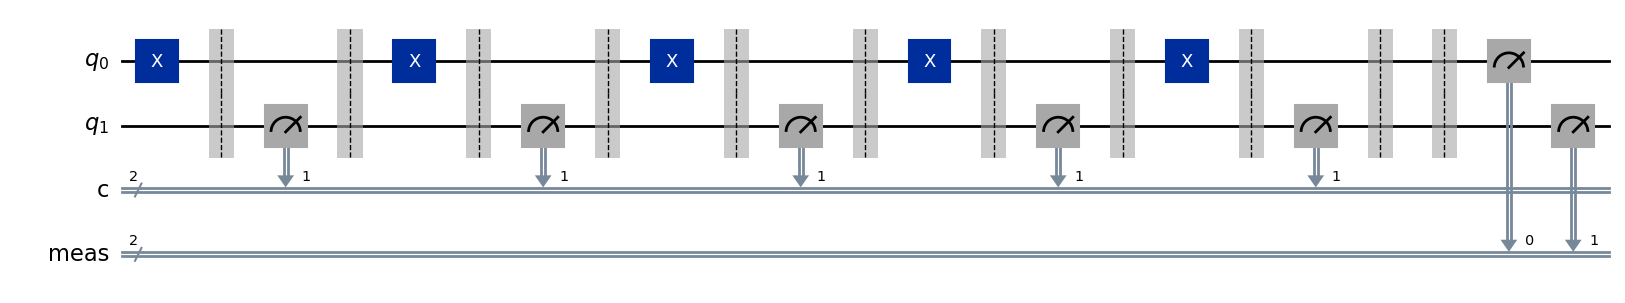

In [8]:
q1 = mcm_rb(5)
q1.draw('mpl')

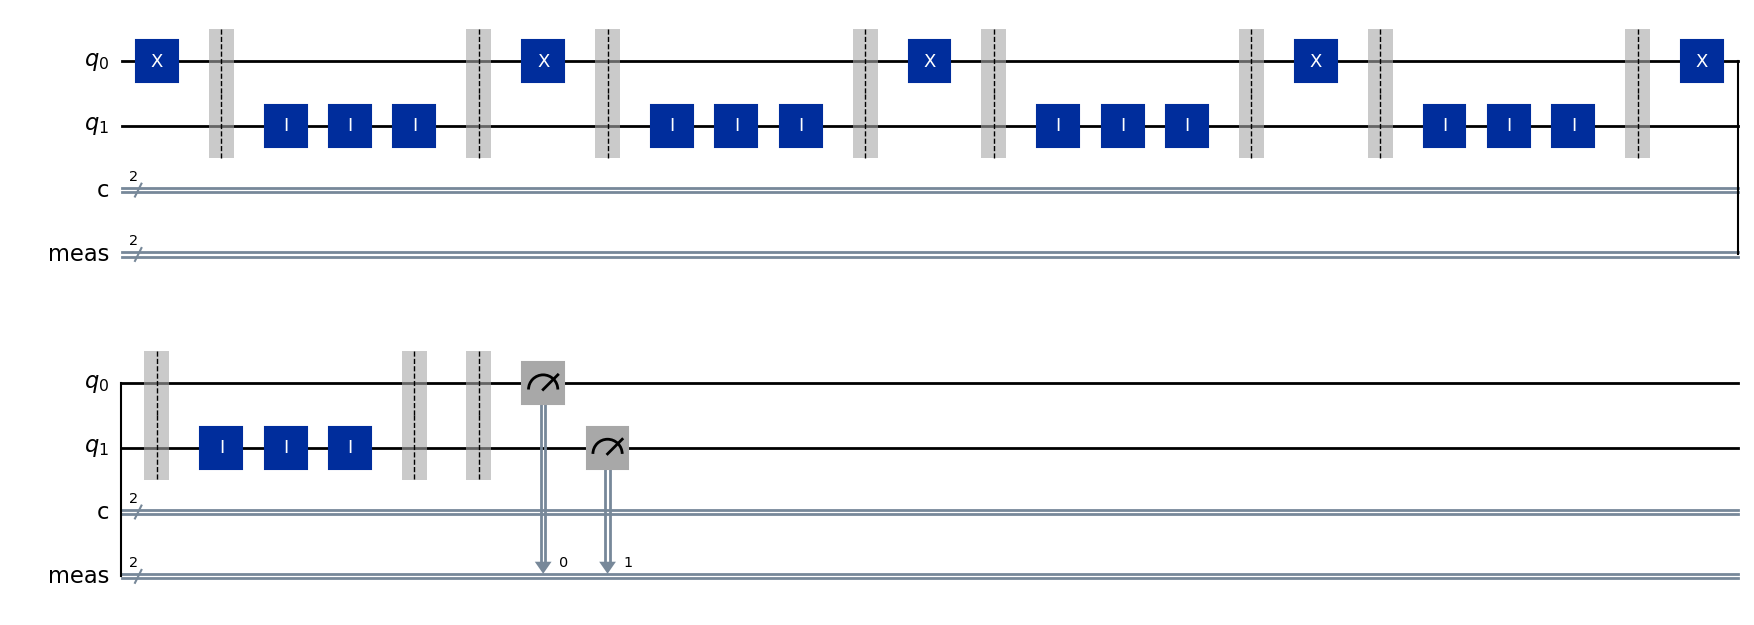

In [9]:
q2 = delay_rb(5)
q2.draw('mpl')

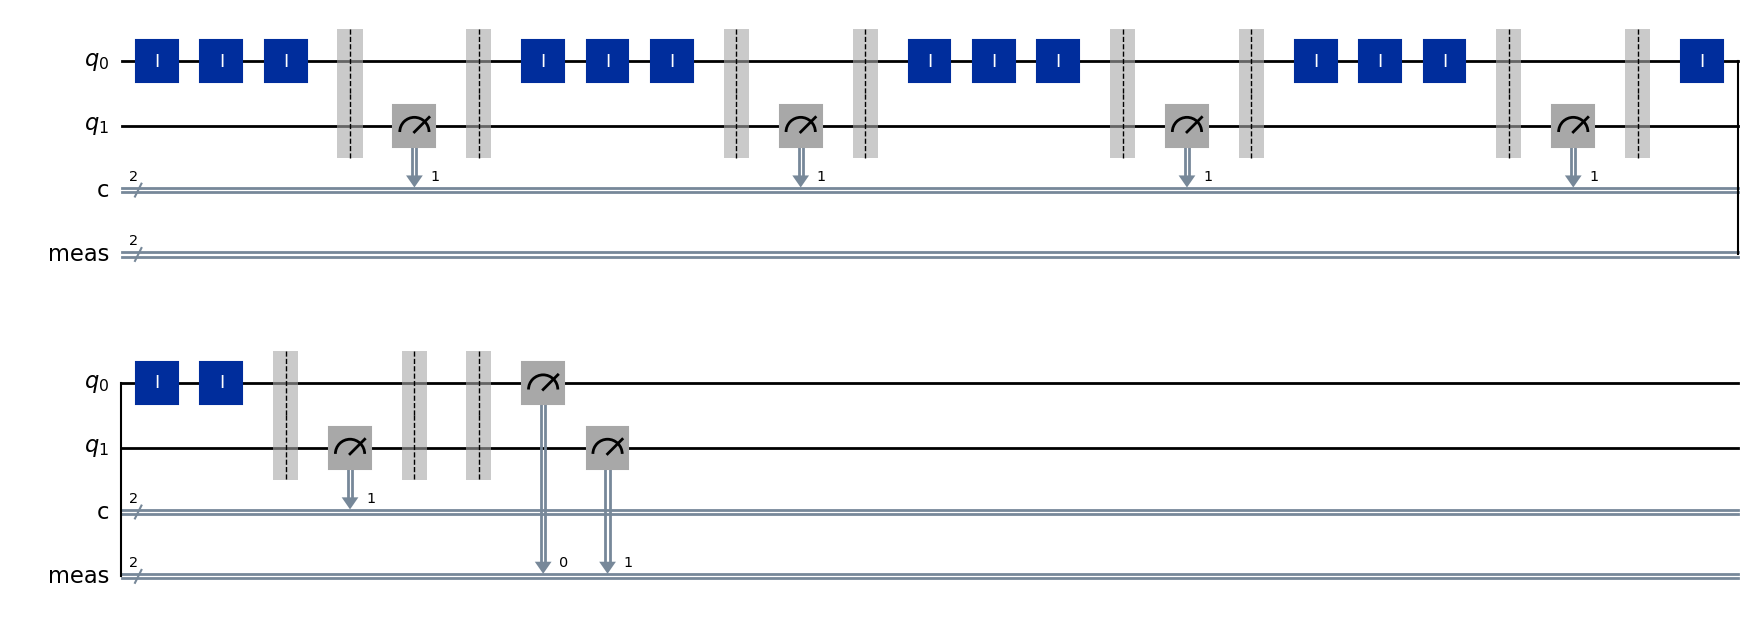

In [10]:
q3 = mcm_rep(5)
q3.draw('mpl')

<h1>Checking circuits run time</h1>

In [11]:
from qiskit_aer import AerSimulator
backend = AerSimulator()

In [12]:
import time
# This function measure the time required for executing the circuit in nanoseconds
def meas_time(backend, qc):

  shots = 1000

  start = time.monotonic_ns()
  circ = transpile(qc, backend, optimization_level = 0)
  # Run
  result = backend.run(circ, shots=shots).result()
  end = time.monotonic_ns()

  return end-start

In the following 3 cells, the time for executing the three different circuits is approximately the same. This is important as when replacing for example the measurement with a sequence that equals identity, we need the duration to stay approximately the same for fair comparison of the results.

In [13]:
sum = 0
for _ in range(2000):
  sum += meas_time(backend, q1)
meas_avg = sum/2000
print(meas_avg)

20717504.3335


In [14]:
sum = 0
for _ in range(2000):
  sum += meas_time(backend, q2)
identity_avg = sum/2000
print(identity_avg)

20727770.5505


In [15]:
sum = 0
for _ in range(2000):
  sum += meas_time(backend, q3)
identity_avg = sum/2000
print(identity_avg)

20977125.434


<h1>Conclusion and remarks</h1>

In [16]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [17]:
def noise(rs=0.0005, meas=0.005, gate=0.008):
    # Example error probabilities
    p_reset = rs
    p_meas = meas
    p_gate1 = gate

    # QuantumError objects
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_bit_flip

In [18]:
def running(qc, backend, shots):
  simulator = backend
  circ = transpile(qc, simulator, optimization_level = 0)

  # Run and get counts
  result = simulator.run(circ, shots=shots).result()
  counts = result.get_counts(circ)
  x = counts['00 00']

  return x

In [19]:
def test(c, rs2=0.0005, meas2=0.008, gate2=0.008):
  values = []
  for n in range(4, 101, 2):
    if c==1:
      qc = mcm_rb(n)
    elif c==2:
      qc = delay_rb(n)
    else:
      qc = mcm_rep(n)
    backend = AerSimulator(noise_model = noise(rs=rs2, meas=meas2, gate=gate2))
    values.append(running(qc, backend, 1000))
  return values

In [20]:
res1 = test(1)
res2 = test(2)
res3 = test(3)
print(res1)
print(res2)
print(res3)

[921, 876, 885, 836, 846, 824, 761, 747, 702, 711, 704, 660, 656, 636, 625, 599, 586, 572, 580, 568, 545, 532, 519, 518, 509, 498, 510, 478, 486, 453, 433, 450, 445, 452, 423, 396, 406, 391, 392, 390, 407, 386, 378, 397, 370, 366, 332, 352, 345]
[958, 928, 930, 913, 924, 893, 877, 853, 856, 829, 815, 816, 799, 766, 778, 771, 770, 768, 768, 727, 737, 734, 735, 728, 703, 667, 692, 690, 680, 674, 669, 651, 676, 656, 656, 665, 617, 619, 625, 652, 607, 584, 617, 623, 612, 611, 583, 568, 610]
[955, 937, 917, 901, 891, 870, 871, 863, 855, 821, 840, 807, 818, 802, 783, 770, 792, 762, 737, 751, 736, 720, 709, 729, 723, 689, 685, 689, 705, 674, 696, 665, 666, 637, 654, 653, 643, 623, 639, 645, 645, 606, 621, 613, 593, 572, 614, 606, 587]


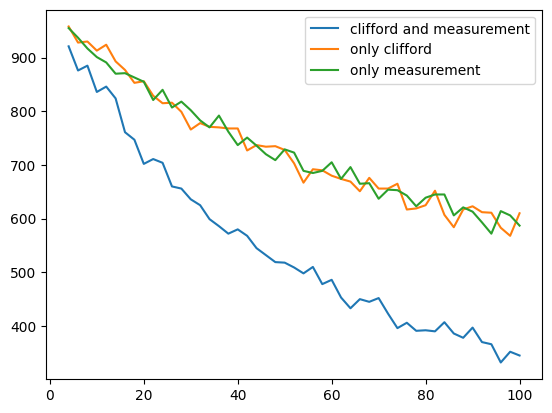

In [21]:
import matplotlib.pyplot as plt
plt.plot(list(range(4, 101, 2)), res1)
plt.plot(list(range(4, 101, 2)), res2)
plt.plot(list(range(4, 101, 2)), res3)
plt.legend(['clifford and measurement', 'only clifford', 'only measurement'])
plt.show()



*   We can see that the effect of measurement in our case is near the effect of an identity gate applied on the second qubit when no clifford gate is applied on the first qubit.
*   Remark: Because some classical processing is done on the circuit sometimes we might get somehow deviated results especially like the functions that calculate the time for the circuit. Since identity gate is done classicaly instead of in a quantum way in qiskit.
*   We can see from the orange and blue graph that having a measurement on our second qubit when a clifford is applied to the first qubit had big effects. It had more worse results than from the orange line(only clifford on first qubit, identity on the second)
*   From these results we can quantify how much measurement is affecting the first qubit.

